<a href="https://colab.research.google.com/github/Paparare/1_textile_recog/blob/main/CV_AEnum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision transformers datasets diffusers transformers pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import zipfile
import os
import re
import csv
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision.models import ResNet50_Weights
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from diffusers import StableDiffusionInpaintPipeline
from diffusers import DiffusionPipeline


[Data download here](https://drive.google.com/file/d/1ja4ZeewIY_CGV5DpOXDOXNoBQ9uu_x5w/view?usp=sharing)

In [ ]:
!pip install gdown

In [ ]:
import gdown

url = 'https://drive.google.com/file/d/1ja4ZeewIY_CGV5DpOXDOXNoBQ9uu_x5w/view?usp=drive_link'
output_path = 'pic.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1ja4ZeewIY_CGV5DpOXDOXNoBQ9uu_x5w
From (redirected): https://drive.google.com/uc?id=1ja4ZeewIY_CGV5DpOXDOXNoBQ9uu_x5w&confirm=t&uuid=58f4bd1e-ef6c-46ee-a65e-e662c4aff8f0
To: /content/pic.zip
100%|██████████| 71.2M/71.2M [00:04<00:00, 17.7MB/s]


'pic.zip'

In [ ]:
# Extract information from filename
def extract_info(filename):
    match = re.search(r'(\d+)a(\d+)e(\d+)', filename)
    if match:
        pic_number = match.group(1)
        warp = int(match.group(2))
        weft = int(match.group(3))
        return pic_number, warp, weft
    return None, None, None

# File paths
zip_path = 'pic.zip'
extract_path = 'extracted_pics'
csv_path = 'warp_weft_data.csv'
combined_dir = 'combined_images'

# Create necessary directories
os.makedirs(extract_path, exist_ok=True)
os.makedirs(combined_dir, exist_ok=True)

# Extract zip file with error handling
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
except zipfile.BadZipFile as e:
    print(f"Error: {e}")
    print("The zip file could not be opened. Please check the file and try again.")
    raise


In [ ]:
pipe = DiffusionPipeline.from_pretrained("timbrooks/instruct-pix2pix")
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
warp_weft_dict = {}
warp_weft_data = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        filename, file_extension = os.path.splitext(file)
        if file_extension in ['.png']:
            pic_number, warp, weft = extract_info(filename)
            if pic_number is not None and warp is not None and weft is not None:
                new_filename = f"{pic_number}{file_extension}"
                old_file_path = os.path.join(root, file)
                new_file_path = os.path.join(root, new_filename)
                os.rename(old_file_path, new_file_path)
                warp_weft_dict[new_filename] = (warp, weft)

                # Load original image
                original_image = Image.open(new_file_path).convert("RGB").resize((512, 512))

                # Save original image to the combined directory
                original_image.save(os.path.join(combined_dir, new_filename))
                warp_weft_data.append([new_filename, warp, weft])

                # Augment the image 20 times and save
                for i in range(20):
                    prompt = "Create a drawing with a different style and color"

                    # Generate augmented image using the pipeline
                    augmented_image = pipe(prompt=prompt, image=original_image).images[0]

                    # Save the augmented image
                    aug_filename = f"{pic_number}_aug_{i+1}{file_extension}"
                    aug_file_path = os.path.join(combined_dir, aug_filename)
                    augmented_image.save(aug_file_path)
                    warp_weft_data.append([aug_filename, warp, weft])

# Save warp and weft data to CSV
with open(csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Filename', 'Warp', 'Weft'])
    csvwriter.writerows(warp_weft_data)

print(f'Images extracted to {extract_path} and warp/weft data, including augmented images, saved to {csv_path}')

In [ ]:
# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images and update CSV
def augment_image(image_path, save_dir, original_filename, warp, weft):
    img = image.load_img(image_path)
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate and save augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        i += 1
        augmented_filename = f'{original_filename.split(".")[0]}_{i:02d}.png'
        augmented_filepath = os.path.join(save_dir, augmented_filename)
        image.save_img(augmented_filepath, batch[0])
        augmented_data.append([augmented_filename, warp, weft])
        if i >= 20:  # Generate 20 augmented images per original image
            break

# Apply augmentation to all images and update the CSV file
augmented_data = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        file_path = os.path.join(root, file)
        warp, weft = warp_weft_dict.get(file, (None, None))
        if warp is not None and weft is not None:
            augment_image(file_path, combined_dir, file, warp, weft)

# Update the CSV file with augmented data
with open(csv_path, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(augmented_data)

print(f'Original and augmented images saved to {combined_dir} and updated warp/weft data saved to {csv_path}')

Original and augmented images saved to combined_images and updated warp/weft data saved to warp_weft_data.csv


In [ ]:
# Define the dataset class
class WeftWarpDataset(Dataset):
    def __init__(self, image_dir, csv_file, target, transform=None):
        self.image_dir = image_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.target == 'weft':
            target_value = self.data.iloc[idx, 2]
        else:
            target_value = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, target_value

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

In [ ]:
# Load the combined CSV data
data = pd.read_csv(csv_path)

train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# Then, split the remaining data into training and validation sets (80% train, 10% validation)
train_data, val_data = train_test_split(train_val_data, test_size=0.1111, random_state=42)

# Save the splits to separate CSV files
train_csv_path = 'warp_weft_train_data.csv'
val_csv_path = 'warp_weft_val_data.csv'
test_csv_path = 'warp_weft_test_data.csv'

train_data.to_csv(train_csv_path, index=False)
val_data.to_csv(val_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

In [ ]:
# Create datasets for weft
train_dataset_weft = WeftWarpDataset(combined_dir, train_csv_path, target='weft', transform=transform)
val_dataset_weft = WeftWarpDataset(combined_dir, val_csv_path, target='weft', transform=transform)
test_dataset_weft = WeftWarpDataset(combined_dir, test_csv_path, target='weft', transform=transform)

# Create data loaders for weft
train_loader_weft = DataLoader(train_dataset_weft, batch_size=64, shuffle=True)
val_loader_weft = DataLoader(val_dataset_weft, batch_size=64, shuffle=False)
test_loader_weft = DataLoader(test_dataset_weft, batch_size=64, shuffle=False)

# Create datasets for warp
train_dataset_warp = WeftWarpDataset(combined_dir, train_csv_path, target='warp', transform=transform)
val_dataset_warp = WeftWarpDataset(combined_dir, val_csv_path, target='warp', transform=transform)
test_dataset_warp = WeftWarpDataset(combined_dir, test_csv_path, target='warp', transform=transform)

# Create data loaders for warp
train_loader_warp = DataLoader(train_dataset_warp, batch_size=64, shuffle=True)
val_loader_warp = DataLoader(val_dataset_warp, batch_size=64, shuffle=False)
test_loader_warp = DataLoader(test_dataset_warp, batch_size=64, shuffle=False)

print("Data loaders created for weft and warp training, validation, and test sets.")

Data loaders created for weft and warp training, validation, and test sets.


In [ ]:
def get_resnet_model():
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)
    return model

# Initialize models
model_weft = get_resnet_model()
model_warp = get_resnet_model()

# Loss function and optimizers
criterion = nn.MSELoss()
optimizer_weft = torch.optim.Adam(model_weft.parameters(), lr=0.001)
optimizer_warp = torch.optim.Adam(model_warp.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm

In [ ]:
num_epochs = 100
best_weft_accuracy = 0.0
best_warp_accuracy = 0.0
patience = 10
early_stop_counter = 0
best_val_loss = float('inf')

# Training and validation for weft model
for epoch in range(num_epochs):
    model_weft.train()
    running_loss = 0.0
    for images, targets in tqdm(train_loader_weft, desc=f"Training Epoch {epoch+1}/{num_epochs} [Weft]"):
        optimizer_weft.zero_grad()
        images = images.to(torch.float32)

        # Debug statement: check image values
        if torch.any(torch.isnan(images)):
            print("NaN values found in images during training!")
            break

        outputs = model_weft(images)
        targets = targets.float().unsqueeze(1)

        # Debug statement: check targets values
        if torch.any(torch.isnan(targets)):
            print("NaN values found in targets during training!")
            break

        loss = criterion(outputs, targets)

        # Debug statement: check loss value
        if torch.isnan(loss):
            print("NaN value found in loss during training!")
            break

        loss.backward()
        optimizer_weft.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader_weft.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}] Weft, Training Loss: {epoch_loss:.4f}')

    # Validation step
    model_weft.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader_weft, desc=f"Validation Epoch {epoch+1}/{num_epochs} [Weft]"):
            images = images.to(torch.float32)
            outputs = model_weft(images)
            targets = targets.float().unsqueeze(1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader_weft.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}] Weft, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    # Evaluate weft model on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in test_loader_weft:
            images = images.to(torch.float32)
            outputs = model_weft(images)
            total += targets.size(0)
            correct += ((outputs - targets.unsqueeze(1)).abs() <= 0.5).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set [Weft]: {accuracy:.4f}')

    # Save the best weft model
    if accuracy > best_weft_accuracy:
        best_weft_accuracy = accuracy
        torch.save(model_weft.state_dict(), 'best_weft_model.pth')

Training Epoch 1/100 [Weft]: 100%|██████████| 10/10 [05:04<00:00, 30.44s/it]


Epoch [1/100] Weft, Training Loss: 0.6198


Validation Epoch 1/100 [Weft]: 100%|██████████| 2/2 [00:14<00:00,  7.32s/it]


Epoch [1/100] Weft, Validation Loss: 0.2418
Accuracy on test set [Weft]: 0.7368


Training Epoch 2/100 [Weft]: 100%|██████████| 10/10 [05:03<00:00, 30.38s/it]


Epoch [2/100] Weft, Training Loss: 0.4678


Validation Epoch 2/100 [Weft]: 100%|██████████| 2/2 [00:13<00:00,  6.83s/it]


Epoch [2/100] Weft, Validation Loss: 0.2220
Accuracy on test set [Weft]: 0.8289


Training Epoch 3/100 [Weft]:  10%|█         | 1/10 [00:33<04:59, 33.26s/it]

In [ ]:
early_stop_counter_warp = 0
best_val_loss_warp = float('inf')

In [ ]:
# Training and validation for warp model
for epoch in range(num_epochs):
    model_warp.train()
    running_loss = 0.0
    for images, targets in tqdm(train_loader_warp, desc=f"Training Epoch {epoch+1}/{num_epochs} [Warp]"):
        optimizer_warp.zero_grad()
        images = images.to(torch.float32)

        # Debug statement: check image values
        if torch.any(torch.isnan(images)):
            print("NaN values found in images during training!")
            break

        outputs = model_warp(images)
        targets = targets.float().unsqueeze(1)

        # Debug statement: check targets values
        if torch.any(torch.isnan(targets)):
            print("NaN values found in targets during training!")
            break

        loss = criterion(outputs, targets)

        # Debug statement: check loss value
        if torch.isnan(loss):
            print("NaN value found in loss during training!")
            break

        loss.backward()
        optimizer_warp.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader_warp.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}] Warp, Training Loss: {epoch_loss:.4f}')

    # Validation step
    model_warp.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader_warp, desc=f"Validation Epoch {epoch+1}/{num_epochs} [Warp]"):
            images = images.to(torch.float32)
            outputs = model_warp(images)
            targets = targets.float().unsqueeze(1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader_warp.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}] Warp, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss_warp:
        best_val_loss_warp = val_loss
        early_stop_counter_warp = 0
    else:
        early_stop_counter_warp += 1
        if early_stop_counter_warp >= patience:
            print("Early stopping triggered for Warp model")
            break

    # Evaluate warp model on test set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in test_loader_warp:
            images = images.to(torch.float32)
            outputs = model_warp(images)
            total += targets.size(0)
            correct += ((outputs - targets.unsqueeze(1)).abs() <= 0.5).sum().item()
    accuracy = correct / total
    print(f'Accuracy on test set [Warp]: {accuracy:.4f}')

    # Save the best warp model
    if accuracy > best_warp_accuracy:
        best_warp_accuracy = accuracy
        torch.save(model_warp.state_dict(), 'best_warp_model.pth')

Training Epoch 1/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.86s/it]


Epoch [1/100] Warp, Training Loss: 12.0122


Validation Epoch 1/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.36s/it]


Epoch [1/100] Warp, Validation Loss: 5787.7968
Accuracy on test set [Warp]: 0.0263


Training Epoch 2/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.76s/it]


Epoch [2/100] Warp, Training Loss: 11.9454


Validation Epoch 2/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.41s/it]


Epoch [2/100] Warp, Validation Loss: 65.1965
Accuracy on test set [Warp]: 0.0789


Training Epoch 3/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.73s/it]


Epoch [3/100] Warp, Training Loss: 8.3709


Validation Epoch 3/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.41s/it]


Epoch [3/100] Warp, Validation Loss: 114.9597
Accuracy on test set [Warp]: 0.1447


Training Epoch 4/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.75s/it]


Epoch [4/100] Warp, Training Loss: 11.0502


Validation Epoch 4/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.48s/it]


Epoch [4/100] Warp, Validation Loss: 24.5867
Accuracy on test set [Warp]: 0.2105


Training Epoch 5/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.75s/it]


Epoch [5/100] Warp, Training Loss: 6.3033


Validation Epoch 5/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.47s/it]


Epoch [5/100] Warp, Validation Loss: 8.5304
Accuracy on test set [Warp]: 0.2500


Training Epoch 6/100 [Warp]: 100%|██████████| 10/10 [05:06<00:00, 30.68s/it]


Epoch [6/100] Warp, Training Loss: 6.2062


Validation Epoch 6/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.45s/it]


Epoch [6/100] Warp, Validation Loss: 20.8288
Accuracy on test set [Warp]: 0.2237


Training Epoch 7/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.73s/it]


Epoch [7/100] Warp, Training Loss: 3.8965


Validation Epoch 7/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.36s/it]


Epoch [7/100] Warp, Validation Loss: 3.4374
Accuracy on test set [Warp]: 0.3158


Training Epoch 8/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.73s/it]


Epoch [8/100] Warp, Training Loss: 3.1894


Validation Epoch 8/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.40s/it]


Epoch [8/100] Warp, Validation Loss: 2.1306
Accuracy on test set [Warp]: 0.2632


Training Epoch 9/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.90s/it]


Epoch [9/100] Warp, Training Loss: 4.9122


Validation Epoch 9/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it]


Epoch [9/100] Warp, Validation Loss: 2.5084
Accuracy on test set [Warp]: 0.3684


Training Epoch 10/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.95s/it]


Epoch [10/100] Warp, Training Loss: 6.7256


Validation Epoch 10/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.47s/it]


Epoch [10/100] Warp, Validation Loss: 2.6984
Accuracy on test set [Warp]: 0.2895


Training Epoch 11/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.94s/it]


Epoch [11/100] Warp, Training Loss: 5.4742


Validation Epoch 11/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


Epoch [11/100] Warp, Validation Loss: 6.4491
Accuracy on test set [Warp]: 0.4211


Training Epoch 12/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.77s/it]


Epoch [12/100] Warp, Training Loss: 5.8983


Validation Epoch 12/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.37s/it]


Epoch [12/100] Warp, Validation Loss: 2.6308
Accuracy on test set [Warp]: 0.3158


Training Epoch 13/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.86s/it]


Epoch [13/100] Warp, Training Loss: 5.9397


Validation Epoch 13/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


Epoch [13/100] Warp, Validation Loss: 4.9254
Accuracy on test set [Warp]: 0.2500


Training Epoch 14/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.82s/it]


Epoch [14/100] Warp, Training Loss: 7.5917


Validation Epoch 14/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.36s/it]


Epoch [14/100] Warp, Validation Loss: 4.3012
Accuracy on test set [Warp]: 0.3553


Training Epoch 15/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.84s/it]


Epoch [15/100] Warp, Training Loss: 5.2905


Validation Epoch 15/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.55s/it]


Epoch [15/100] Warp, Validation Loss: 8.9273
Accuracy on test set [Warp]: 0.2500


Training Epoch 16/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.91s/it]


Epoch [16/100] Warp, Training Loss: 6.6566


Validation Epoch 16/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.58s/it]


Epoch [16/100] Warp, Validation Loss: 21.9770
Accuracy on test set [Warp]: 0.3553


Training Epoch 17/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.91s/it]


Epoch [17/100] Warp, Training Loss: 3.5960


Validation Epoch 17/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it]


Epoch [17/100] Warp, Validation Loss: 2.4229
Accuracy on test set [Warp]: 0.2895


Training Epoch 18/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.92s/it]


Epoch [18/100] Warp, Training Loss: 3.4250


Validation Epoch 18/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.52s/it]


Epoch [18/100] Warp, Validation Loss: 0.7319
Accuracy on test set [Warp]: 0.6053


Training Epoch 19/100 [Warp]: 100%|██████████| 10/10 [05:14<00:00, 31.47s/it]


Epoch [19/100] Warp, Training Loss: 1.6768


Validation Epoch 19/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.56s/it]


Epoch [19/100] Warp, Validation Loss: 1.3891
Accuracy on test set [Warp]: 0.4474


Training Epoch 20/100 [Warp]: 100%|██████████| 10/10 [05:14<00:00, 31.41s/it]


Epoch [20/100] Warp, Training Loss: 1.7843


Validation Epoch 20/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it]


Epoch [20/100] Warp, Validation Loss: 2.0494
Accuracy on test set [Warp]: 0.5526


Training Epoch 21/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.87s/it]


Epoch [21/100] Warp, Training Loss: 1.5928


Validation Epoch 21/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]


Epoch [21/100] Warp, Validation Loss: 1.0423
Accuracy on test set [Warp]: 0.3026


Training Epoch 22/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.96s/it]


Epoch [22/100] Warp, Training Loss: 2.6451


Validation Epoch 22/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


Epoch [22/100] Warp, Validation Loss: 2.5740
Accuracy on test set [Warp]: 0.2500


Training Epoch 23/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.93s/it]


Epoch [23/100] Warp, Training Loss: 1.8286


Validation Epoch 23/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.56s/it]


Epoch [23/100] Warp, Validation Loss: 0.7334
Accuracy on test set [Warp]: 0.5526


Training Epoch 24/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.94s/it]


Epoch [24/100] Warp, Training Loss: 2.1868


Validation Epoch 24/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it]


Epoch [24/100] Warp, Validation Loss: 0.7170
Accuracy on test set [Warp]: 0.5263


Training Epoch 25/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.95s/it]


Epoch [25/100] Warp, Training Loss: 1.0866


Validation Epoch 25/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]


Epoch [25/100] Warp, Validation Loss: 0.7481
Accuracy on test set [Warp]: 0.3684


Training Epoch 26/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.87s/it]


Epoch [26/100] Warp, Training Loss: 1.2327


Validation Epoch 26/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.52s/it]


Epoch [26/100] Warp, Validation Loss: 0.3796
Accuracy on test set [Warp]: 0.5658


Training Epoch 27/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.92s/it]


Epoch [27/100] Warp, Training Loss: 1.0646


Validation Epoch 27/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


Epoch [27/100] Warp, Validation Loss: 0.8002
Accuracy on test set [Warp]: 0.4605


Training Epoch 28/100 [Warp]: 100%|██████████| 10/10 [05:09<00:00, 30.95s/it]


Epoch [28/100] Warp, Training Loss: 1.5188


Validation Epoch 28/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.60s/it]


Epoch [28/100] Warp, Validation Loss: 0.8618
Accuracy on test set [Warp]: 0.4474


Training Epoch 29/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.90s/it]


Epoch [29/100] Warp, Training Loss: 0.8645


Validation Epoch 29/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it]


Epoch [29/100] Warp, Validation Loss: 1.1486
Accuracy on test set [Warp]: 0.4605


Training Epoch 30/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.83s/it]


Epoch [30/100] Warp, Training Loss: 1.0245


Validation Epoch 30/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.51s/it]


Epoch [30/100] Warp, Validation Loss: 0.3230
Accuracy on test set [Warp]: 0.6053


Training Epoch 31/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.79s/it]


Epoch [31/100] Warp, Training Loss: 1.2933


Validation Epoch 31/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.38s/it]


Epoch [31/100] Warp, Validation Loss: 0.4920
Accuracy on test set [Warp]: 0.4474


Training Epoch 32/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.78s/it]


Epoch [32/100] Warp, Training Loss: 0.6608


Validation Epoch 32/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]


Epoch [32/100] Warp, Validation Loss: 0.8669
Accuracy on test set [Warp]: 0.6842


Training Epoch 33/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.73s/it]


Epoch [33/100] Warp, Training Loss: 0.9327


Validation Epoch 33/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it]


Epoch [33/100] Warp, Validation Loss: 0.6659
Accuracy on test set [Warp]: 0.5263


Training Epoch 34/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.74s/it]


Epoch [34/100] Warp, Training Loss: 1.5747


Validation Epoch 34/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.55s/it]


Epoch [34/100] Warp, Validation Loss: 0.5117
Accuracy on test set [Warp]: 0.4211


Training Epoch 35/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.81s/it]


Epoch [35/100] Warp, Training Loss: 3.0542


Validation Epoch 35/100 [Warp]: 100%|██████████| 2/2 [00:15<00:00,  7.51s/it]


Epoch [35/100] Warp, Validation Loss: 3.0525
Accuracy on test set [Warp]: 0.3684


Training Epoch 36/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.78s/it]


Epoch [36/100] Warp, Training Loss: 1.8945


Validation Epoch 36/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.40s/it]


Epoch [36/100] Warp, Validation Loss: 3.4425
Accuracy on test set [Warp]: 0.1316


Training Epoch 37/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.79s/it]


Epoch [37/100] Warp, Training Loss: 0.8723


Validation Epoch 37/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.44s/it]


Epoch [37/100] Warp, Validation Loss: 0.9260
Accuracy on test set [Warp]: 0.5526


Training Epoch 38/100 [Warp]: 100%|██████████| 10/10 [05:07<00:00, 30.75s/it]


Epoch [38/100] Warp, Training Loss: 1.3371


Validation Epoch 38/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


Epoch [38/100] Warp, Validation Loss: 1.0780
Accuracy on test set [Warp]: 0.5000


Training Epoch 39/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.86s/it]


Epoch [39/100] Warp, Training Loss: 0.8422


Validation Epoch 39/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.45s/it]


Epoch [39/100] Warp, Validation Loss: 0.9763
Accuracy on test set [Warp]: 0.4211


Training Epoch 40/100 [Warp]: 100%|██████████| 10/10 [05:08<00:00, 30.88s/it]


Epoch [40/100] Warp, Training Loss: 0.6777


Validation Epoch 40/100 [Warp]: 100%|██████████| 2/2 [00:14<00:00,  7.42s/it]

Epoch [40/100] Warp, Validation Loss: 0.3412
Early stopping triggered for Warp model


# **Case study 4*4**
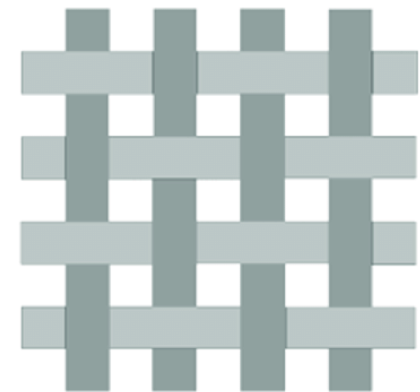

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

model_weft = get_resnet_model()
model_weft.load_state_dict(torch.load('weft_model.pth'))
model_weft.eval()
model_warp = get_resnet_model()
model_warp.load_state_dict(torch.load('warp_model.pth'))
model_warp.eval()

!ls
image_path = '888.png'
image = Image.open(image_path).convert("RGB")

image_tensor = transform(image).unsqueeze(0)
with torch.no_grad():
    weft_prediction = model_weft(image_tensor).item()
    warp_prediction = model_warp(image_tensor).item()

print(f'Predicted Weft: {weft_prediction}')
print(f'Predicted Warp: {warp_prediction}')